# Building Models
1. **Create Commonly Used Functions**
1. **Start Modeling**
1. **Remove/Add Features as necessary**
1. **Finalize Model** 
1. **Investigate points of weakness**

In [590]:
import pandas as pd
import numpy as np
import seaborn as sns
import dtale
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [667]:
df1 = pd.read_pickle('cleaned_analysis_dataframe.pkl')
df = pd.read_pickle('cleaned_full_dataframe.pkl')

In [668]:
df1.sample(5)

,accommodates,bathrooms,bedrooms,price,cleaning_fee,guests_included,distance(km),size,id,name,summary,space,description,host_response_time,host_is_superhost,neighbourhood_group_cleansed,city,room_type,beds,bed_type,amenities,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,days_rented,amen_patio,amen_dryer,amen_family_friendly,amen_parking,amen_laptop,amen_tv,count_amenities,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,host_response_time_within a few hours,host_response_time_within an hour,cancellation_policy_flexible,room_type_Entire home/apt,neighbourhood_labels,len_desc,len_space,monthly_cash_flow,median_cash_flow,target
9225,3,1.0,1.0,60,20.0,1,5.578281,59.857275,29654583,Altbauwohnung mit Charme im Herzen Berlins,NaN,Wunderschöne Altbauwohnung mit Balkon im Prenz...,Wunderschöne Altbauwohnung mit Balkon im Prenz...,within an hour,0,Pankow,Berlin,Entire home/apt,2.0,Real Bed,"{TV,Kitchen,""Pets allowed"",Heating,Washer,Esse...",97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0.00,203,0,0,0,0,0,1,9,0,0,0,1,0,1,1,1,6,110.0,110.0,1015.000000,1627.750000,0
14202,2,1.0,1.0,55,0.0,1,6.700788,20.000000,21162755,Cosy room in Berlin Mitte with a green view,Room : A beautiful and cosy flat is waiting fo...,NaN,Room : A beautiful and cosy flat is waiting fo...,NaN,1,Mitte,Berlin,Private room,1.0,Real Bed,"{Wifi,Kitchen,""Free street parking"",Heating,Es...",100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0.45,340,0,0,0,1,1,0,12,0,0,0,1,0,0,0,0,4,648.0,0.0,1558.333333,850.000000,1
11659,2,1.0,1.0,40,0.0,1,4.186413,48.076479,20756708,Cozy room in berlin Friedrichshain,cozy apartment in the heart of berlin Friedric...,The Apartment is basic and cozy and offers eve...,cozy apartment in the heart of berlin Friedric...,NaN,0,Friedrichshain-Kreuzberg,Berlin,Private room,1.0,Real Bed,"{Wifi,Kitchen,""Free parking on premises"",""Pets...",100.0,10.0,8.0,10.0,10.0,10.0,8.0,1,flexible,0.24,340,0,0,0,0,1,0,13,0,0,0,1,0,0,1,0,1,614.0,63.0,1133.333333,912.958333,1
11398,3,1.0,2.0,76,0.0,2,3.832253,64.503359,18931777,Ruhiges Zimmer in zentraler Maisonette,Unsere Wohnung befindet sich im schönen und ru...,NaN,Unsere Wohnung befindet sich im schönen und ru...,NaN,0,Friedrichshain-Kreuzberg,Berlin,Private room,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Elevator,""Buzzer/w...",97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,moderate,0.00,340,0,0,1,0,0,1,12,0,0,0,1,0,0,0,0,1,269.0,0.0,2153.333333,912.958333,1
15440,10,1.5,3.0,199,0.0,1,6.836204,121.892877,23660343,"Bis zu 10 Personen, City West, drei Zimmer.","Eine sehr große, schöne und saubere drei Zimme...",Seit dem 1. März werden Küche und Bad/WC regel...,"Eine sehr große, schöne und saubere drei Zimme...",within an hour,0,Charlottenburg-Wilm.,Berlin,Entire home/apt,10.0,Real Bed,"{Wifi,Kitchen,""Free street parking"",Heating,""F...",86.0,9.0,9.0,10.0,10.0,9.0,9.0,1,strict_14_with_grace_period,3.54,305,0,0,1,1,0,0,17,0,0,0,1,0,1,0,1,0,1000.0,756.0,5057.916667,1322.583333,1


==============================================================================================================
# 1. Build the common Functions

In [781]:
def build_pipeline(X_train, y_train):
    pipelines = []
    n_estimators = 100
    pipelines.append( ('Support Vector',
                       Pipeline([('sc', StandardScaler()),
                                 ('SVC', SVC())]) ) )
    pipelines.append( ('Random Forest',
                       Pipeline([('sc', StandardScaler()),
                                ('RF', RandomForestClassifier(n_estimators=n_estimators)) ]) ))
    pipelines.append( ('Logistic Regression',
                       Pipeline([('sc', StandardScaler()),
                                 ('LR', LogisticRegression()) ]) ))

    results, names = [], [] 
    num_folds = 10
    scoring = 'accuracy'

    for name, model in pipelines:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring,
                                    n_jobs=-1) 
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (+/- %f)" % (name, 100*cv_results.mean(), 
                                                           100*cv_results.std())
        print(msg)

    fig = plt.figure(figsize=(12,8))    
    fig.suptitle("Algorithms comparison", size=16, weight='bold')
    ax = fig.add_subplot(1,1,1)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.ylabel('Accuracy', size=16, weight='bold')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.show()


In [777]:
def show_rfc(X_train, X_test, y_train, y_test, estimators = 100, threshold=.5):
    rfc = RandomForestClassifier(n_estimators=estimators)
    rfc.fit(X_train, y_train)
    pred_tr = rfc.predict(X_train)
    pred_te = rfc.predict(X_test)
    rfc_confusion = metrics.confusion_matrix(y_test, pred_te)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc.predict_proba(X_test)[:,1])

    sns.heatmap(rfc_confusion, cmap=plt.cm.Blues, annot=True, fmt='d',
           xticklabels=['Below_average', 'Above_average'],
           yticklabels=['Below_average', 'Above_average'], annot_kws={"size": 15}
               );
    plt.xlabel('prediction\n', size=16, weight='bold')
    plt.ylabel('actual \n', size=16, weight='bold')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.title('Random Forest Output \n', size=16, weight='bold')
    importances = list(zip(X_train.columns, rfc.feature_importances_))
    df_import = pd.DataFrame(importances,columns=['feature', 'rating'])
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x='rating', y='feature', data=df_import.sort_values(by='rating', ascending=False))
    print(metrics.classification_report(y_test, pred_te))
    def plot_roc(fpr, tpr):
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr,lw=2, label='Random Forest')
        plt.plot([0,1],[0,1],c='violet',ls='--', label='No Logic')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.xlabel('False Positive Rate', size=15, weight='bold')
        plt.ylabel('True Positive Rate', size=15, weight='bold')
        plt.legend()
        plt.title('ROC Curve-Random Forest', size=16, weight='bold');
        print("ROC AUC score = ", metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))
    def prec_recall():    
        precision_curve, recall_curve, threshold_curve = metrics.precision_recall_curve(y_test, rfc.predict_proba(X_test)[:,1] )
        plt.figure(dpi=80)
        plt.plot(threshold_curve, precision_curve[1:],label='precision')
        plt.plot(threshold_curve, recall_curve[1:], label='recall')
        plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a Buy)')
        plt.ylabel('Precision and Recall Scores')
        plt.title('Precision and Recall Curves', size=16, weight='bold');
        y_predict = (rfc.predict_proba(X_test)[:, 1] > 0.4)
        print("F1 Score: ", metrics.f1_score(y_test, y_predict))
    plot_roc(fpr, tpr)
    prec_recall()

================================================================================================
# 2. Modeling

### 2-1: Using just continuous features: 
* 'accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee','guests_included', 'distance(km)', 'size', 'beds','review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value', 'len_desc','len_space',

In [665]:
feat1 = ['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee','guests_included', 'distance(km)', 
         'size', 'beds','review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 
         'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value',
         'len_desc','len_space']
X1 = df1[feat1]
y1 = df1['target']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=12)

Support Vector: 73.237321 (+/- 1.076307)
Random Forest: 77.586419 (+/- 0.887960)
Linear Regression: 71.569525 (+/- 1.396741)
Naive Bayes: 60.906373 (+/- 1.420800)


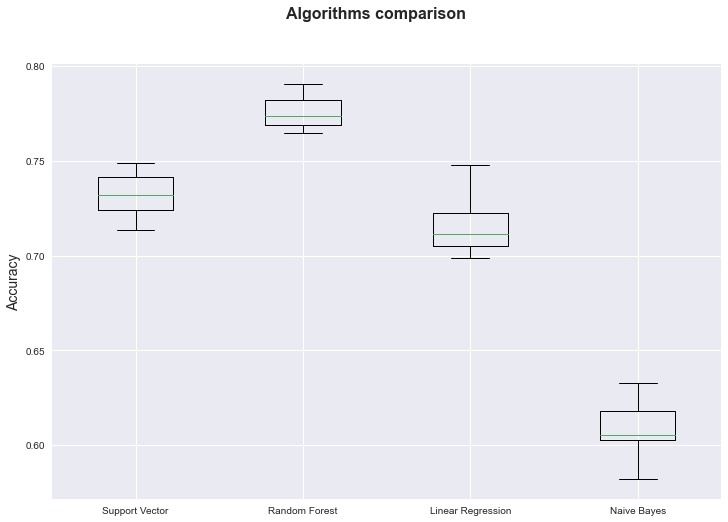

In [666]:
build_pipeline(X1_train, y1_train)

### 2-2: Include Categorical Variables: 

In [672]:
feat2 = ['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee','guests_included', 'distance(km)', 
         'size', 'beds','review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 
         'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value', 
         'host_is_superhost', 'amen_patio', 'amen_dryer', 'amen_family_friendly','amen_parking', 'amen_laptop', 
         'amen_tv', 'count_amenities','bed_type_Couch', 'bed_type_Futon','bed_type_Pull-out Sofa', 
         'bed_type_Real Bed',
         'host_response_time_within a few hours','host_response_time_within an hour', 'cancellation_policy_flexible',
         'room_type_Entire home/apt', 
        'len_desc', 'len_space', 'neighbourhood_labels']
X2 = df1[feat2]
y2 = df1['target']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=12)

Support Vector: 81.597761 (+/- 0.744125)
Random Forest: 85.676611 (+/- 0.790371)
Linear Regression: 79.328631 (+/- 0.730166)
Naive Bayes: 60.879359 (+/- 1.278050)


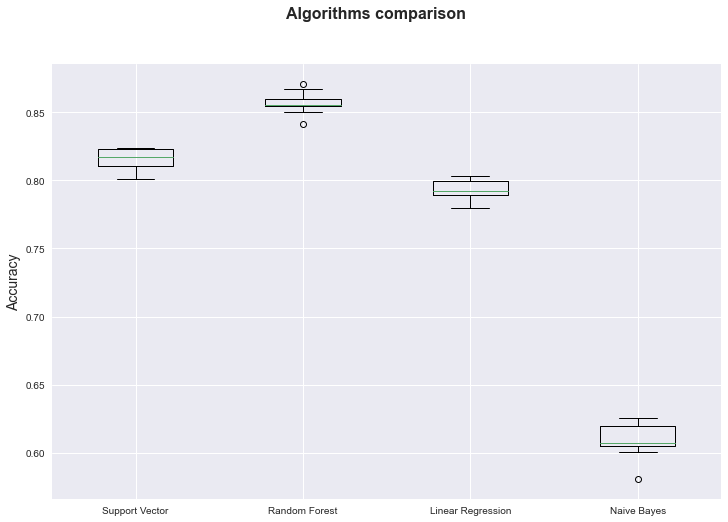

In [673]:
build_pipeline(X2_train, y2_train)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2540
           1       0.83      0.91      0.87      2396

    accuracy                           0.86      4936
   macro avg       0.87      0.87      0.86      4936
weighted avg       0.87      0.86      0.86      4936

ROC AUC score =  0.9262198809038686
F1 Score:  0.8694322309309883


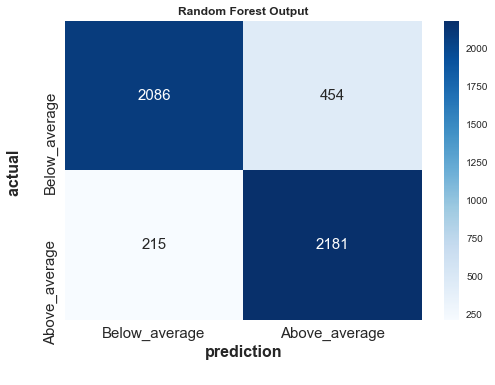

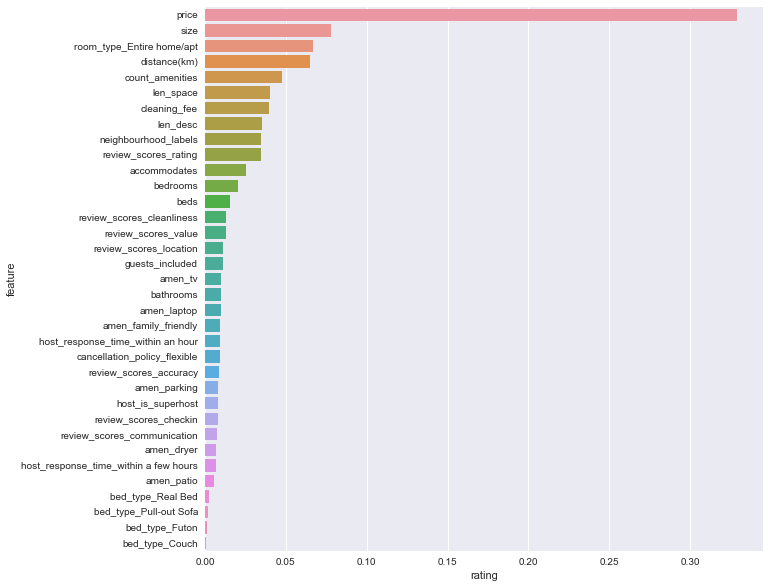

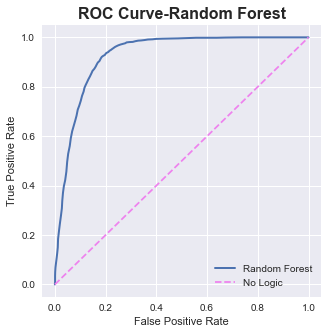

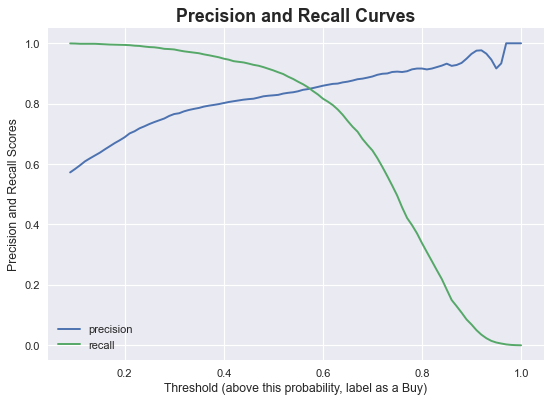

In [773]:
show_rfc(X2_train, X2_test, y2_train, y2_test)

**Conclusions: I can remove the following items since they don't seem to matter** 

- Seems like bed type doesn't matter.  
- Super strict cancellation policies dont seem to add much since there were so few of them
- Review scores other than the overall Rating- Possible since people don't really look at the breakdown of scores


In [675]:
# Just want to double check with Logistic Regression model to see if there is similar result which it seems is the case
log_reg = Logit(y2_train, X2_train).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.518458
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                14808
Model:                          Logit   Df Residuals:                    14773
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.2517
Time:                        20:33:08   Log-Likelihood:                -7677.3
converged:                       True   LL-Null:                       -10260.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
accommodates                              0.0940      0.030      3.171      0.002       0.036       0.152
bathrooms                                -0.1268      0.078     -1.619      0.105      -0.280       0.027
bedrooms                                  0.1589      0.050      3.192      0.001       0.061       0.257
price                                     0.0739      0.002     47.309      0.000       0.071       0.077
cleaning_fee                             -0.0139      0.001    -10.157      0.000      -0.017      -0.011
guests_included                          -0.1511      0.041     -3.659      0.000      -0.232      -0.070
distance(km)                             -0.0091      0.009     -1.022      0.307      -0.026       0.008
size                                     -0.0002      0.001     -0.271      0.786      -0.002       0.001
beds                                     -0.2939      0.036     -8.059      0.000      -0.365      -0.222
review_scores_rating                      0.0104      0.005      2.114      0.035       0.001       0.020
review_scores_accuracy                   -0.0421      0.043     -0.984      0.325      -0.126       0.042
review_scores_cleanliness                 0.0166      0.028      0.585      0.558      -0.039       0.072
review_scores_checkin                    -0.0894      0.042     -2.114      0.034      -0.172      -0.007
review_scores_communication               0.0537      0.045      1.182      0.237      -0.035       0.143
review_scores_location                   -0.0227      0.033     -0.683      0.494      -0.088       0.042
review_scores_value                       0.0278      0.039      0.712      0.476      -0.049       0.104
host_is_superhost                        -0.0688      0.063     -1.091      0.275      -0.193       0.055
amen_patio                                0.4863      0.079      6.191      0.000       0.332       0.640
amen_dryer                               -0.0845      0.064     -1.318      0.187      -0.210       0.041
amen_family_friendly                      0.0867      0.046      1.878      0.060      -0.004       0.177
amen_parking                              0.0286      0.054      0.526      0.599      -0.078       0.135
amen_laptop                               0.0484      0.044      1.094      0.274      -0.038       0.135
amen_tv                                   0.0222      0.045      0.498      0.618      -0.065       0.110
count_amenities                          -0.0227      0.004     -5.986      0.000      -0.030      -0.015
bed_type_Couch                           -2.1662      0.510     -4.250      0.000      -3.165      -1.167
bed_type_Futon                           -2.8310      0.428     -6.612      0.000      -3.670      -1.992
bed_type_Pull-out Sofa                   -2.4472      0.410     -5.968      0.000      -3.251      -1.643
bed_type_Real Bed                        -2.5321      0.388  

### 2-3: See which variables I can remove: 

In [680]:
feat3 = ['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee','guests_included', 'distance(km)', 
         'size', 'beds','review_scores_rating', 'host_is_superhost', 'amen_patio', 'amen_dryer', 
         'amen_parking', 'amen_tv', 'count_amenities',
         'host_response_time_within a few hours','host_response_time_within an hour', 
         'cancellation_policy_flexible', 'room_type_Entire home/apt', 'len_desc', 'len_space', 
         'neighbourhood_labels']
X3 = df1[feat3]
y3 = df1['target']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=12)

Support Vector: 83.123812 (+/- 0.900586)
Random Forest: 85.933235 (+/- 0.703310)
Logistic Regression: 79.504188 (+/- 0.850136)


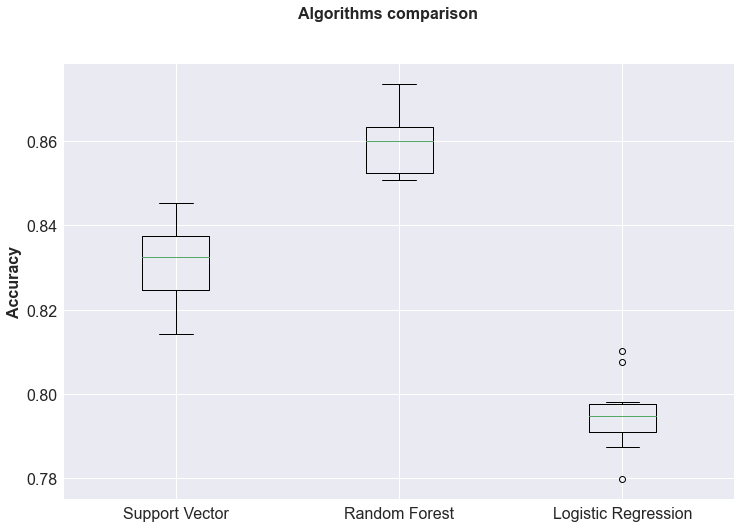

In [782]:
build_pipeline(X3_train, y3_train)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2540
           1       0.83      0.92      0.87      2396

    accuracy                           0.87      4936
   macro avg       0.87      0.87      0.87      4936
weighted avg       0.87      0.87      0.87      4936

ROC AUC score =  0.9300992960708793
F1 Score:  0.877928013711674


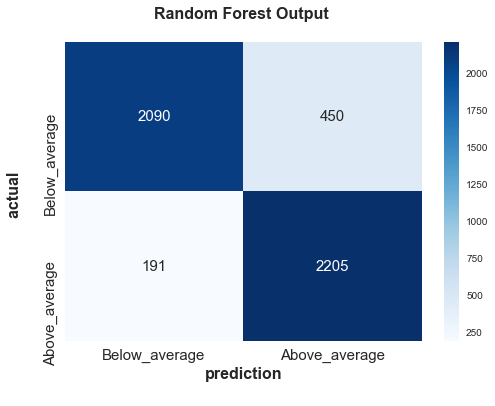

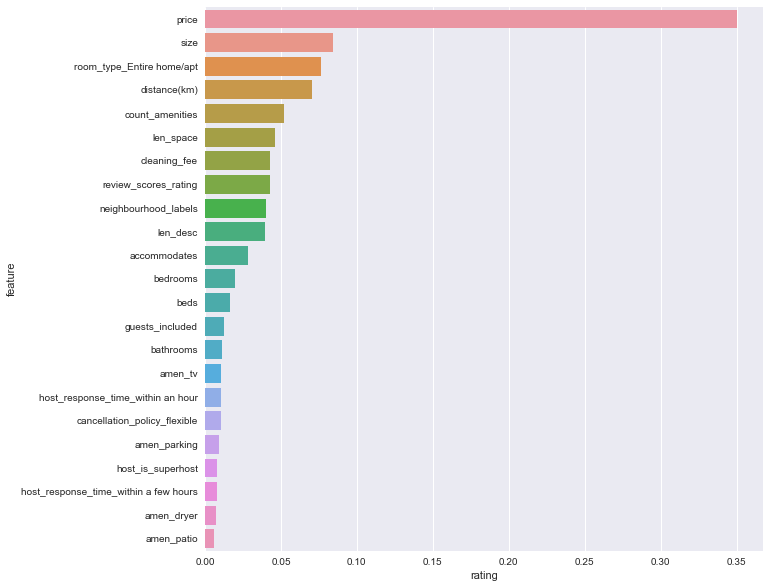

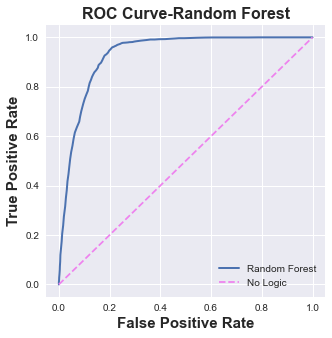

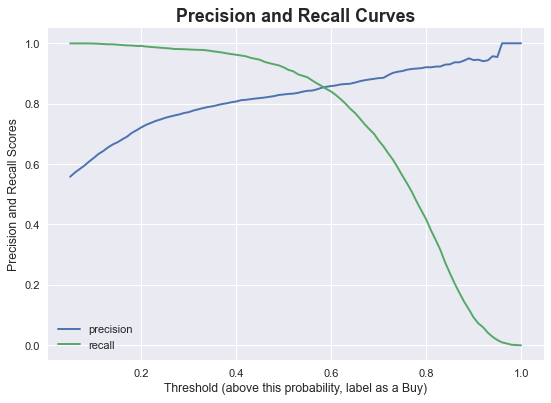

In [778]:
show_rfc(X3_train, X3_test, y3_train, y3_test)

In [683]:
#Tuning the # of estimators.  100 may be too many: 
estimators = list(range(1, 100, 5))
prec = []
rec = []
acc = []
f_one = []
for i in range(1, 100, 5):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X3_train, y3_train)
    pred_tr = rfc.predict(X3_train)
    pred_te = rfc.predict(X3_test)
    rfc_confusion = metrics.confusion_matrix(y3_test, pred_te) 
    acc.append(metrics.accuracy_score(y3_test, pred_te))
    prec.append(metrics.precision_score(y3_test, pred_te))
    rec.append(metrics.recall_score(y3_test, pred_te))
    f_one.append(metrics.f1_score(y3_test, pred_te))

/opt/miniconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/miniconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/miniconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/miniconda3/envs/metis/lib/

<AxesSubplot:>

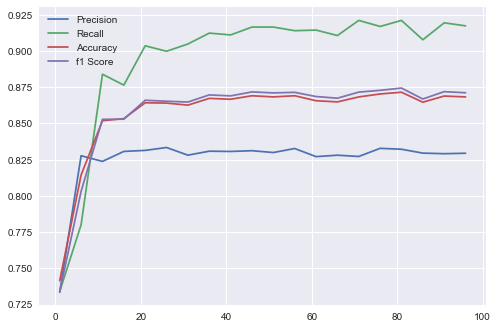

In [684]:
#As suspected, it looks like the scores top out at around 60.  I will keep 60 as the n_estimators moving forward
estimators = list(range(1, 100, 5))
sns.lineplot(estimators, prec, label='Precision')
sns.lineplot(estimators, rec, label='Recall')
sns.lineplot(estimators, acc, label='Accuracy')
sns.lineplot(estimators, f_one, label='f1 Score')


### Looking at predicted vs actual data.  Export


In [795]:
pred_all = rfc.predict(X3)

In [796]:
df1['Predicted'] = pred_all

In [797]:
df1.to_csv('Final_Output.csv')